In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skgarden import RandomForestQuantileRegressor
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

np.random.seed(42)
boston = load_boston()
data_train, data_eval, target_train, target_eval = \
    train_test_split(boston['data'], boston['target'], test_size=0.3, random_state=42)

In [23]:
def plot_eval_prediction_interval(target_eval, prediction, lower_error_list, upper_error_list, figsize=(10, 7)):
    x = range(len(prediction))
    permutation_sorted_ground_truth = target_eval.argsort()
    y = target_eval[permutation_sorted_ground_truth]
    sorted_predictions = prediction[permutation_sorted_ground_truth]
    upper_error = np.array(upper_error_list)[permutation_sorted_ground_truth] - sorted_predictions
    lower_error = sorted_predictions - np.array(lower_error_list)[permutation_sorted_ground_truth]

    plt.figure(figsize=figsize)
    plt.plot(x, y, color='c', marker='o', markersize=6, label='True values', linestyle='None')
    plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', label='Predicted values', capsize=3)
    plt.ylabel('Response value')
    plt.xlabel('Sample no.')
    plt.legend(loc='upper left')
    plt.show()

In [24]:
def compute_prediction_interval(model, data_eval, percentile=95):
    decision_tree_list = model.estimators_
    lower_bound = (100 - percentile) / 2.
    upper_bound = 100 - lower_bound
    # this is the matrix of each predictions for each trees
    decision_tree_prediction_matrix = [_compute_prediction_of_each_tree(decision_tree_list, data_eval[i]) for i in
                                       range(len(data_eval))]
    lower_bound_prediction_list = [np.percentile(prediction_list, lower_bound) for prediction_list in
                                   decision_tree_prediction_matrix]
    upper_bound_prediction_list = [np.percentile(prediction_list, upper_bound) for prediction_list in
                                   decision_tree_prediction_matrix]
    return lower_bound_prediction_list, upper_bound_prediction_list


def _compute_prediction_of_each_tree(decision_tree_list, row):
    # reshaping is mandatory to avoid scikit warning
    reshaped_row = row.reshape(1, -1)
    return [decision_tree.predict(reshaped_row)[0] for decision_tree in decision_tree_list]

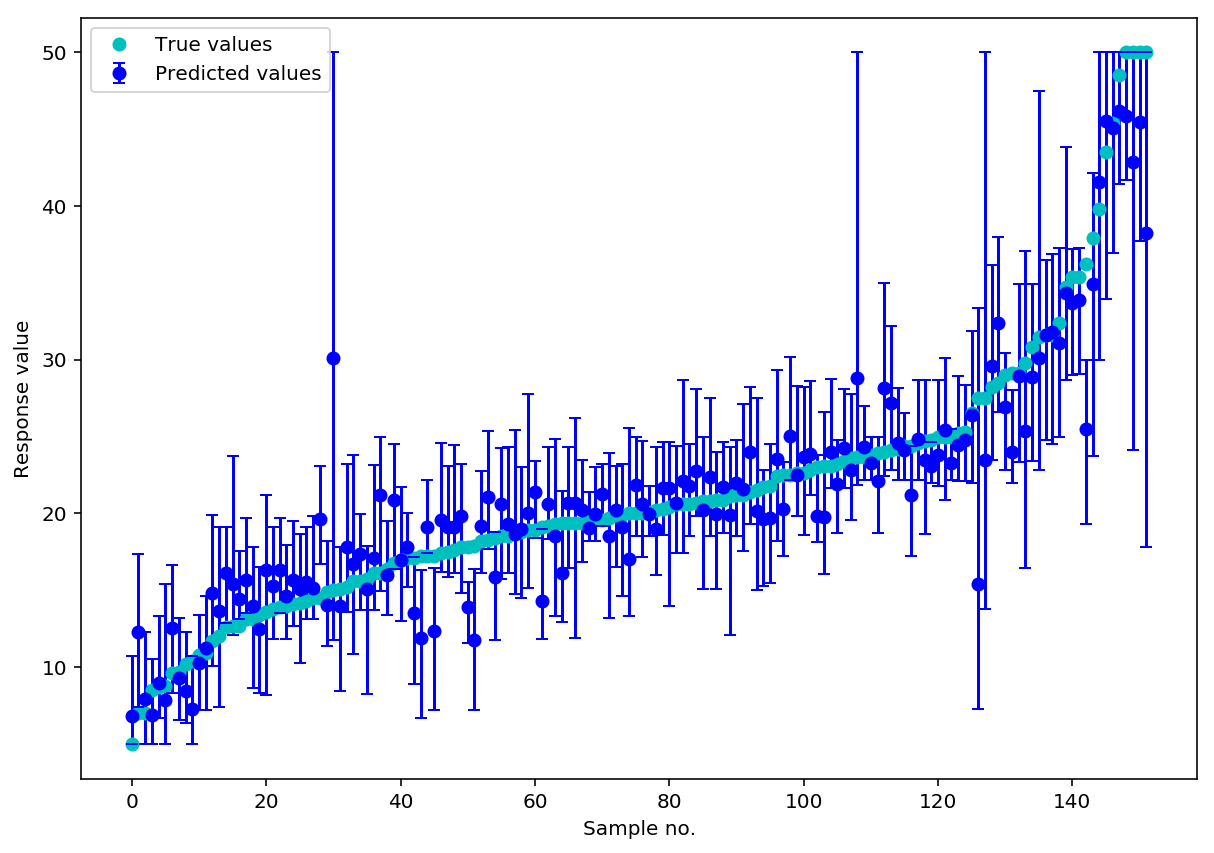

In [25]:
rfqr = RandomForestQuantileRegressor(n_estimators=1000, n_jobs=-1)
rfqr.fit(data_train, target_train)

upper = rfqr.predict(data_eval, quantile=95)
lower = rfqr.predict(data_eval, quantile=5)
mean = rfqr.predict(data_eval)
median = rfqr.predict(data_eval, quantile=50)

plot_eval_prediction_interval(target_eval, mean, lower, upper)

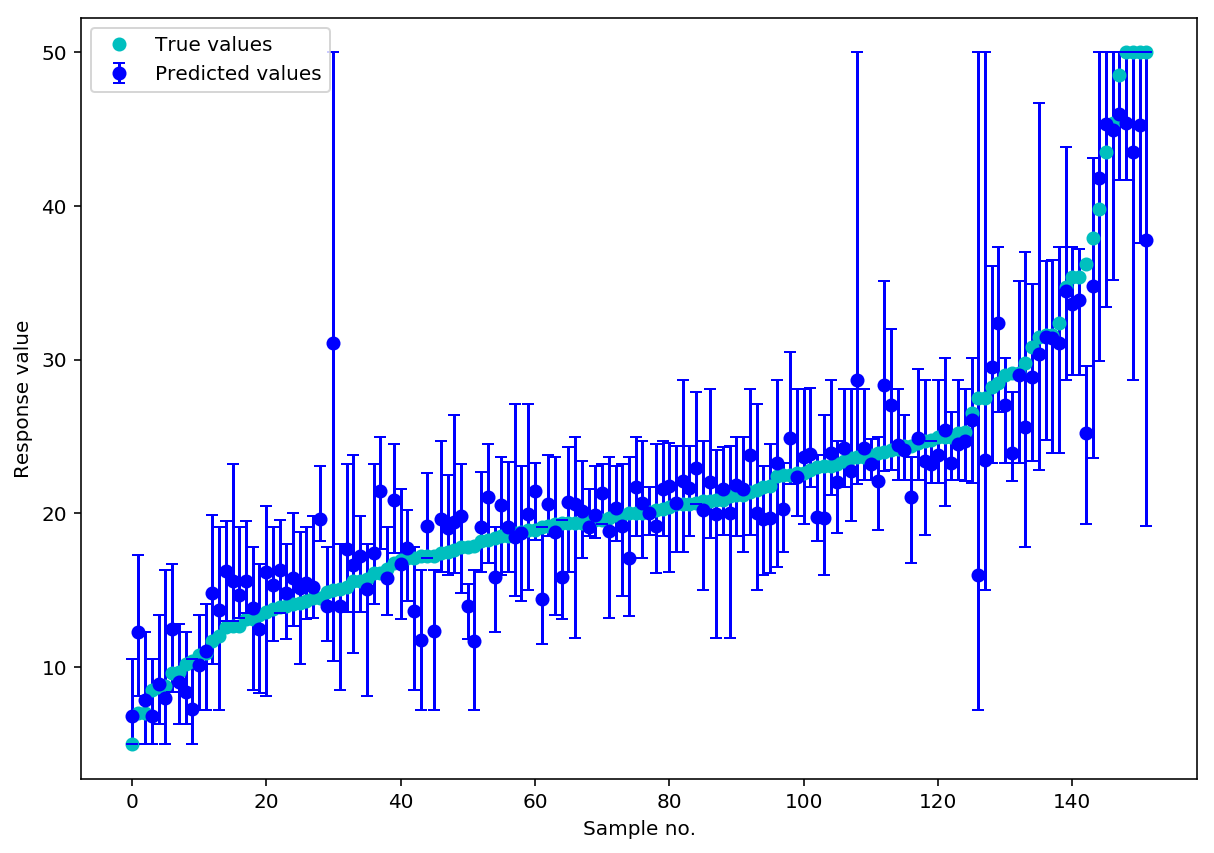

In [26]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=1)
rf.fit(data_train, target_train)
prediction = rf.predict(data_eval)
lower_error_list, upper_error_list = compute_prediction_interval(rf, data_eval, percentile=90)

plot_eval_prediction_interval(target_eval, prediction, lower_error_list, upper_error_list)

## Comparison between predi interval from reg quantile and hand method

In [27]:
mean_squared_error(target_eval, prediction)

9.522617030328957

In [28]:
mean_squared_error(target_eval, median)

8.344072441313367

In [29]:
mean_squared_error(target_eval, mean)

9.30666832789475

## Meilleurs résultats avec median ou mean de quantil reg :)

In [9]:
def test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval(min_samples_leaf=1):
    # Given
    boston = load_boston()
    data_train, data_eval, target_train, target_eval = train_test_split(
        boston['data'], boston['target'], test_size=0.3, random_state=42)
    rfqr = RandomForestQuantileRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=min_samples_leaf)
    rfqr.fit(data_train, target_train)
    # When
    upper_error_list = rfqr.predict(data_eval, quantile=95)
    lower_error_list = rfqr.predict(data_eval, quantile=5)

    # Then
    ground_truth_inside_interval = 0
    for i, target_value in enumerate(target_eval):
        if lower_error_list[i] <= target_value <= upper_error_list[i]:
            ground_truth_inside_interval += 1
    ground_truth_inside_interval_percentage = ground_truth_inside_interval / float(len(target_eval))
    # check that we have roughly 90% of ground truth value inside the computed interval
    return ground_truth_inside_interval_percentage

In [10]:
test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval(min_samples_leaf=1)

0.8947368421052632

In [11]:
test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval(min_samples_leaf=10)

0.9210526315789473

## Plus robuste que l'autre méthode lorsqu'on coupe les arbres :)

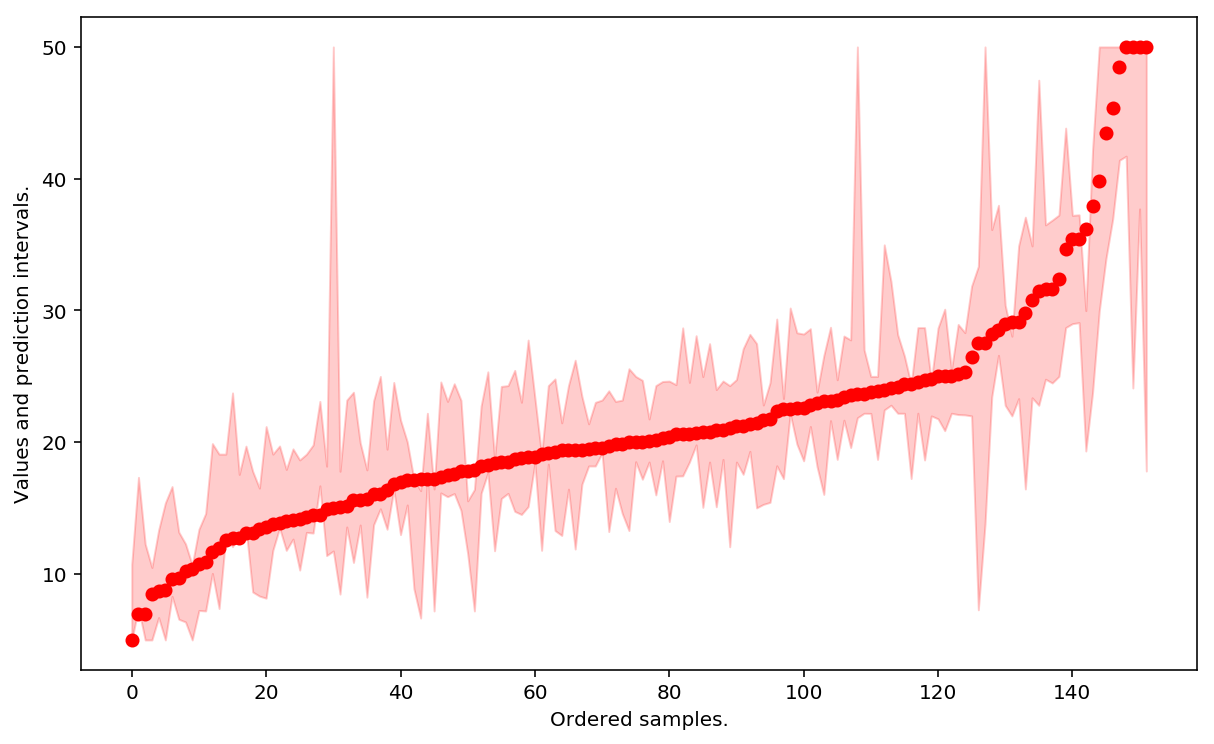

In [30]:
permutation_sorted_ground_truth = target_eval.argsort()

plt.figure(figsize=(10, 6))
plt.plot(target_eval[permutation_sorted_ground_truth], "ro")
plt.fill_between(np.arange(len(upper)), lower[permutation_sorted_ground_truth], upper[permutation_sorted_ground_truth], alpha=0.2, color="r", label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.show()

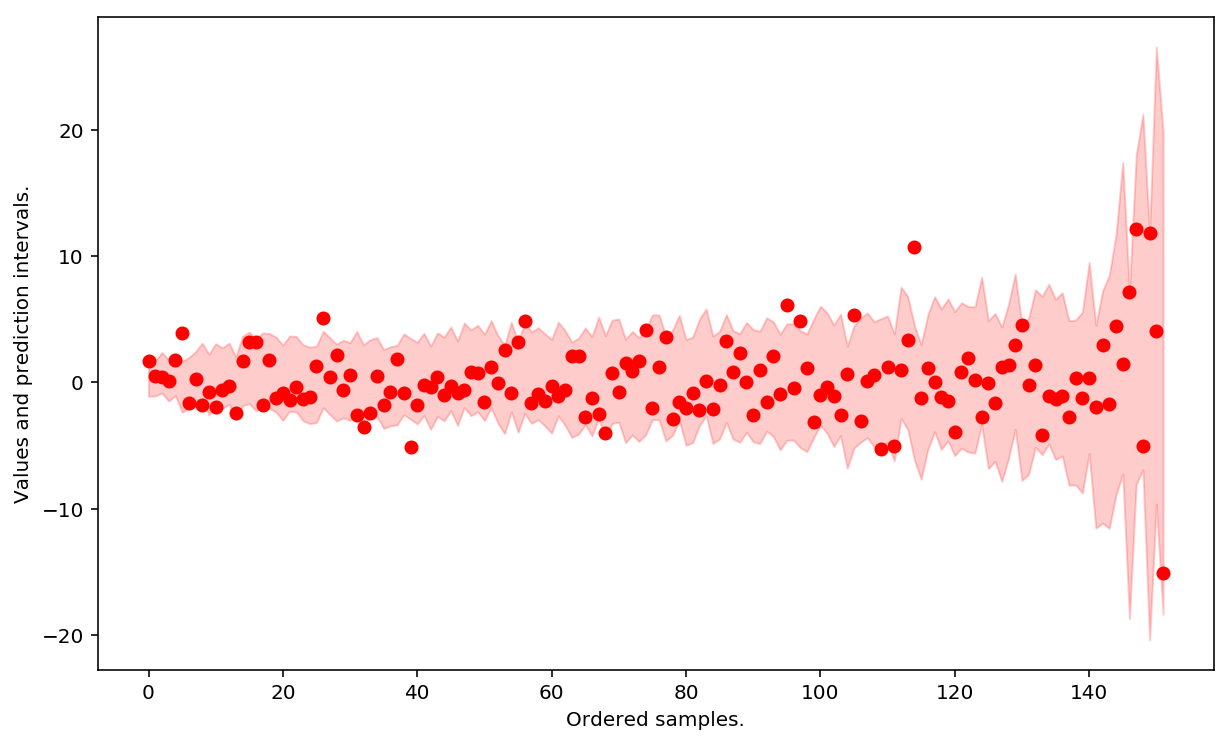

In [31]:
# On centre sur la prediction
adjusted_target_eval = target_eval - mean
adjusted_upper = upper - mean
adjusted_lower = lower - mean

interval = adjusted_upper - adjusted_lower
sort_ind = np.argsort(interval)

plt.figure(figsize=(10, 6))
plt.plot(adjusted_target_eval[sort_ind], "ro")
plt.fill_between(np.arange(len(adjusted_upper)), adjusted_lower[sort_ind], adjusted_upper[sort_ind], alpha=0.2, color="r", label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.show()

## Des viz moufmouf intéressantes

mean: 0.21394806622915907
std: 2.8806767722655335


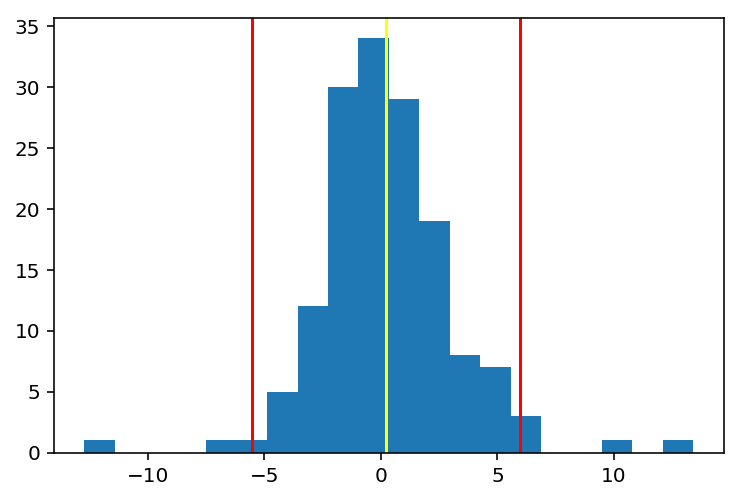

In [32]:
errors = target_eval - median
print('mean:', errors.mean())
print('std:', errors.std())
plt.hist(errors, bins=20)
plt.axvline(x=errors.mean() + 2*errors.std(), color='red')
plt.axvline(x=errors.mean() - 2*errors.std(), color='red')
plt.axvline(x=errors.mean(), color='yellow')
plt.show()

## Distribution des erreurs

In [ ]:
abs_error = abs(target_eval - median)
np.corrcoef(interval, abs_error)[0][1]

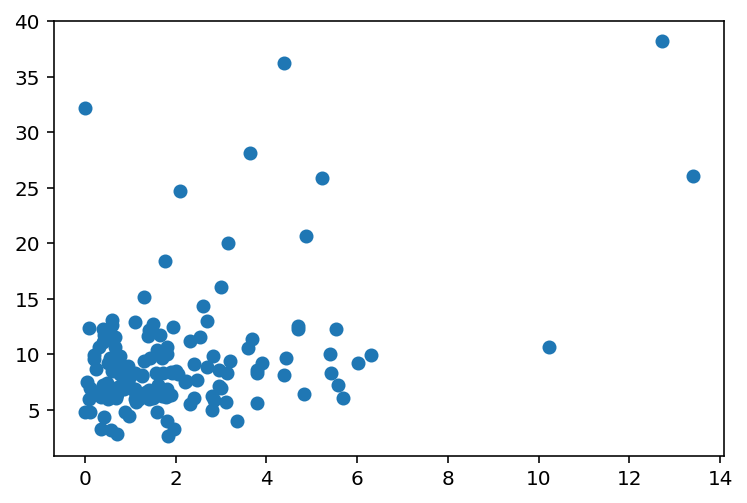

In [18]:
plt.scatter(abs_error, interval);

## Corrélation entre erreur et intervalle de prediction

# Article

In [4]:
train = pd.read_csv('./superconduct/train.csv')
unique_m = pd.read_csv('./superconduct/unique_m.csv')

In [5]:
superconductivty = pd.concat([train, unique_m.drop(['material', 'critical_temp'], axis=1)], axis=1, sort=False)
print(superconductivty.shape)
superconductivty = superconductivty.sample(n=8000)
print(superconductivty.shape)

y_superconductivty = superconductivty['critical_temp']
superconductivty.drop('critical_temp', axis=1, inplace=True)

(21263, 168)
(8000, 168)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    superconductivty,
    y_superconductivty,
    #test_size=0.025/2,
    test_size=0.3,
    random_state=6
)

In [77]:
rf = RandomForestRegressor(criterion='mse', n_estimators=1000, n_jobs=-1, min_samples_leaf=1)
rf.fit(X_train, y_train)
test_prediction = rf.predict(X_test)

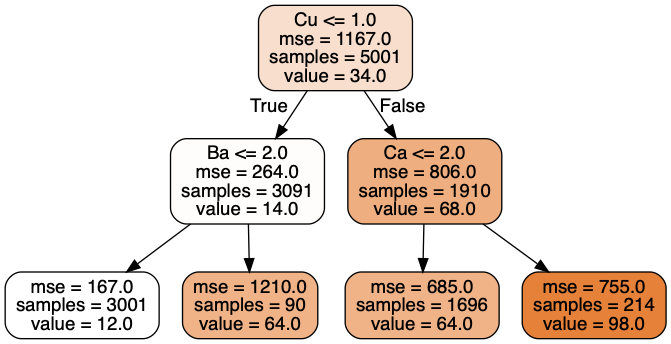

In [71]:
import os
from sklearn.tree import export_graphviz
export_graphviz(rf.estimators_[850],
                out_file='tree_superconduct.dot',
                #max_depth=1,
                precision=0,
                feature_names=X_train.columns,
                filled=True,
                #rotate=True,
                rounded=True)
os.system('dot -Tpng tree_superconduct.dot -o tree_superconduct.png')
from IPython.display import Image
Image(filename = 'tree_superconduct.png')

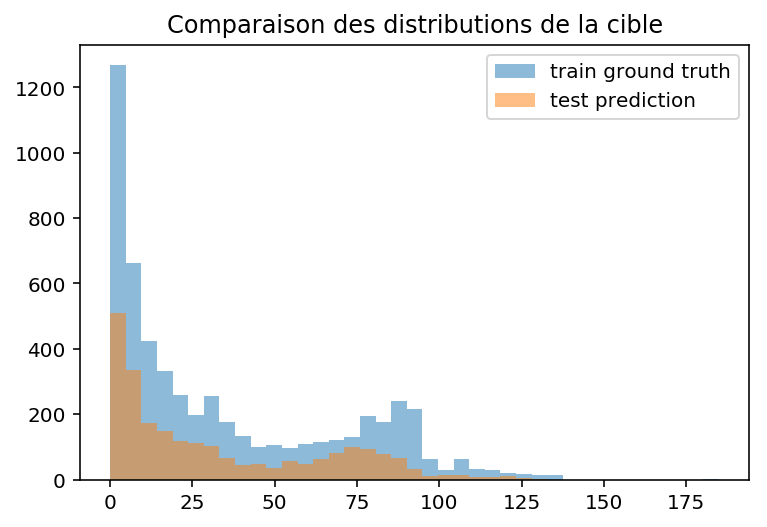

In [78]:
def plot_distribution_comparison(y_train, test_prediction, bins):
    bins = np.linspace(min(y_train), max(y_train), bins)
    plt.hist(y_train, bins, alpha=0.5, label='train ground truth')
    plt.hist(test_prediction, bins, alpha=0.5, label='test prediction')
    plt.title('Comparaison des distributions de la cible')
    plt.legend(loc='upper right')
    plt.show()

plot_distribution_comparison(y_train, test_prediction, 40)

In [79]:
x = range(len(test_prediction))
permutation_sorted_ground_truth = y_test.argsort()
y = y_test.reset_index().critical_temp[permutation_sorted_ground_truth]
sorted_predictions = test_prediction[permutation_sorted_ground_truth]

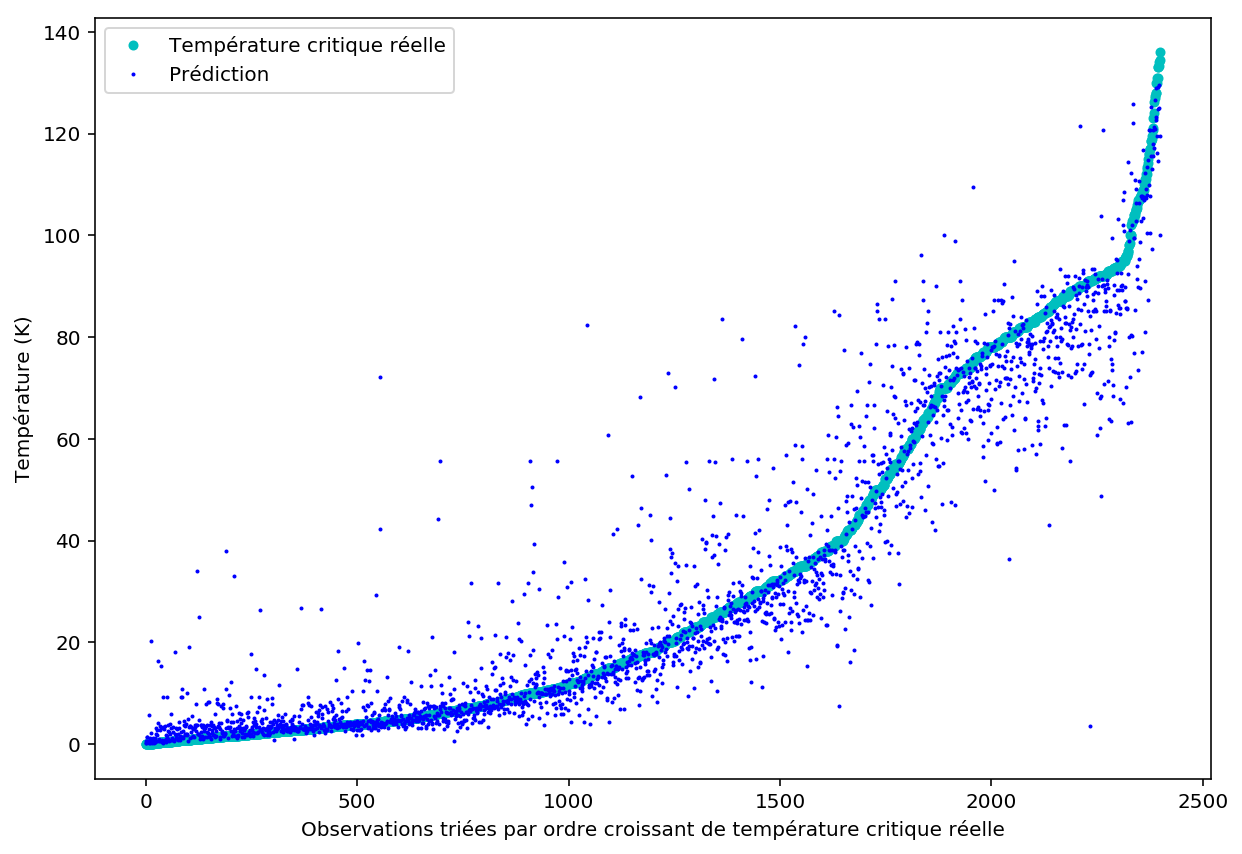

In [80]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, color='c', marker='o', markersize=4, label='Température critique réelle', linestyle='None')
plt.plot(x, sorted_predictions, color='b', marker='o', markersize=1, label='Prédiction', linestyle='None')
plt.ylabel('Température (K)')
plt.xlabel('Observations triées par ordre croissant de température critique réelle')
plt.legend(loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, test_prediction)**(1/2)

9.520548424916806

In [12]:
decision_tree_prediction_matrix = [[dt.predict(np.array([X_test.iloc[i]]))[0] for dt in rf.estimators_] for i in
                                   range(len(X_test))]

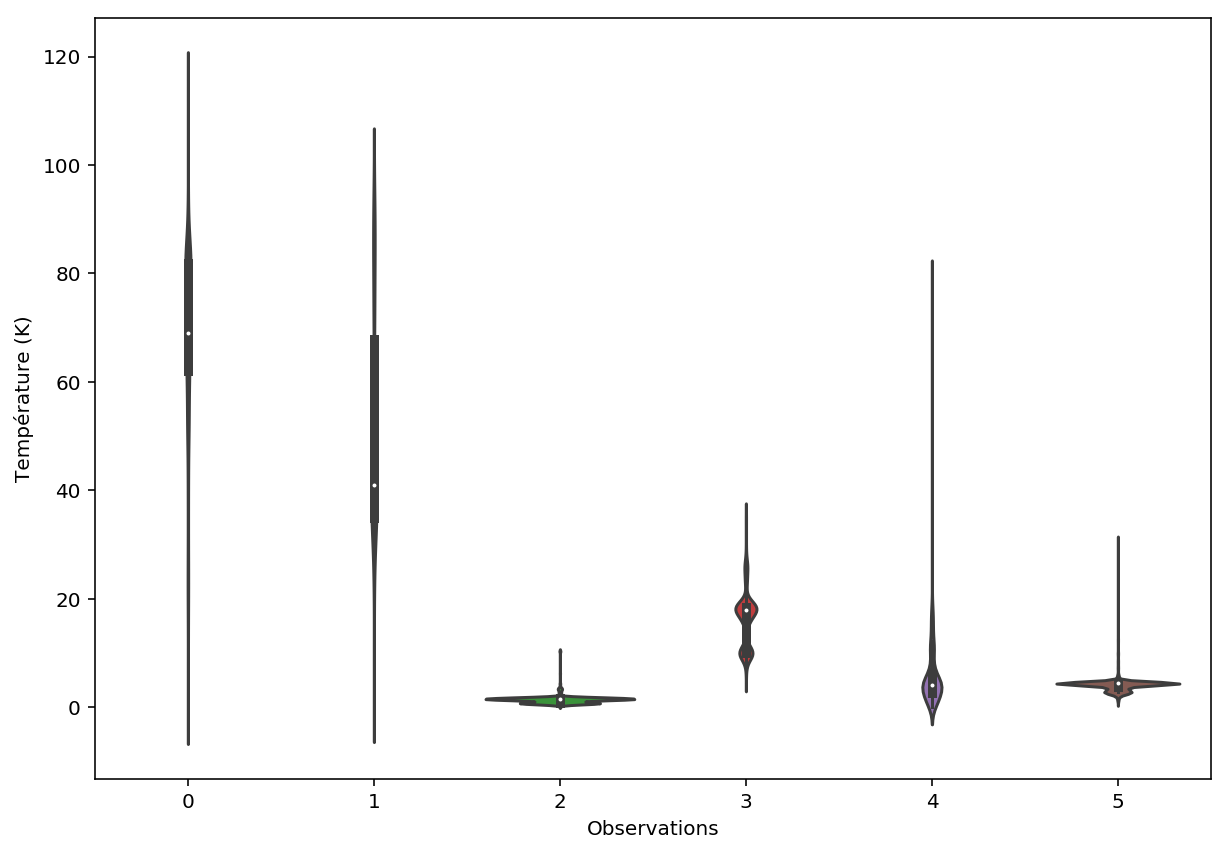

In [13]:
import seaborn as sns

pred_distribution = pd.concat([pd.DataFrame(
    {'Température (K)': decision_tree_prediction_matrix[i],
     'Observations': j}) for i, j in zip([97, 6, 7, 16, 28, 45], range(6))])
plt.figure(figsize=(10, 7))
sns.violinplot(x='Observations', y='Température (K)', data=pred_distribution);

In [14]:
rfqr = RandomForestQuantileRegressor(criterion='mse', n_estimators=1000, n_jobs=-1, min_samples_leaf=100)
rfqr.fit(X_train, y_train);

In [15]:
test_upper = rfqr.predict(X_test, quantile=95)
test_lower = rfqr.predict(X_test, quantile=5)

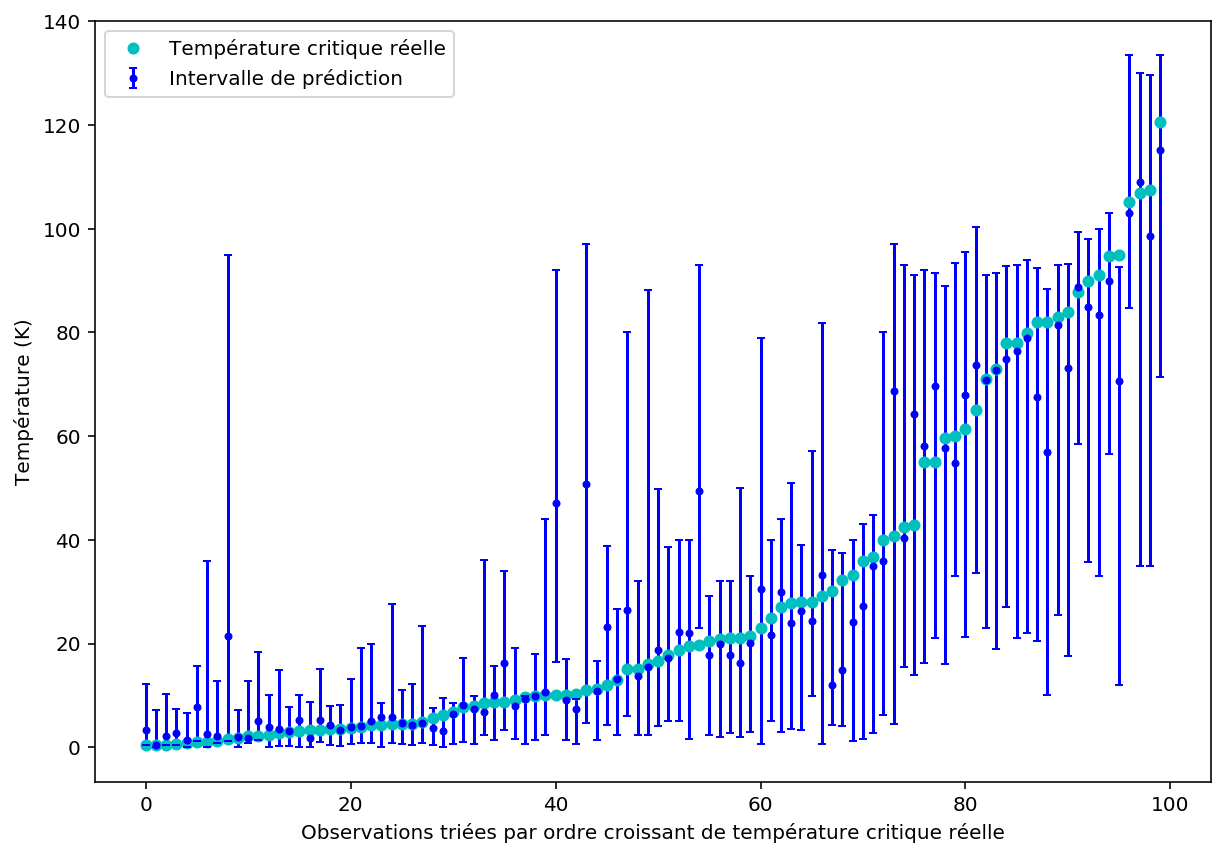

In [16]:
upper_error = test_upper[permutation_sorted_ground_truth] - sorted_predictions
lower_error = sorted_predictions - test_lower[permutation_sorted_ground_truth]

plt.figure(figsize=(10, 7))
plt.plot(x, y, color='c', marker='o', markersize=5, label='Température critique réelle', linestyle='None')
plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', markersize=3, label='Intervalle de prédiction', capsize=2)
plt.ylabel('Température (K)')
plt.xlabel('Observations triées par ordre croissant de température critique réelle')
plt.legend(loc='upper left')
plt.show()

In [17]:
ground_truth_inside_interval = 0
for i, y_value in enumerate(y_test):
    if test_lower[i] <= y_value <= test_upper[i]:
        ground_truth_inside_interval += 1
ground_truth_inside_interval_percentage = ground_truth_inside_interval / float(len(y_test))
ground_truth_inside_interval_percentage

0.94

In [21]:
interval_len = test_upper - test_lower
abs_error = abs(y_test - test_prediction)
np.corrcoef(interval_len, abs_error)[0, 1]

0.5509675249611412

In [22]:
from scipy.stats.stats import pearsonr
pearsonr(interval_len, abs_error)

(0.5509675249611413, 2.8561258119099066e-09)

In [36]:
rf = RandomForestRegressor(criterion='mse', n_estimators=1000, n_jobs=-1, min_samples_leaf=600)
rf.fit(X_train, y_train)
test_prediction = rf.predict(X_test)

In [37]:
x = range(len(test_prediction))
permutation_sorted_ground_truth = y_test.argsort()
y = y_test.reset_index().critical_temp[permutation_sorted_ground_truth]
sorted_predictions = test_prediction[permutation_sorted_ground_truth]

In [38]:
decision_tree_prediction_matrix = [[dt.predict(np.array([X_test.iloc[i]]))[0] for dt in rf.estimators_] for i in
                                   range(len(X_test))]
lower_bound_prediction_list = [np.percentile(prediction_list, 5) for prediction_list in
                               decision_tree_prediction_matrix]
upper_bound_prediction_list = [np.percentile(prediction_list, 95) for prediction_list in
                               decision_tree_prediction_matrix]

In [39]:
upper_error = np.array(upper_bound_prediction_list)[permutation_sorted_ground_truth] - sorted_predictions
lower_error = sorted_predictions - np.array(lower_bound_prediction_list)[permutation_sorted_ground_truth]

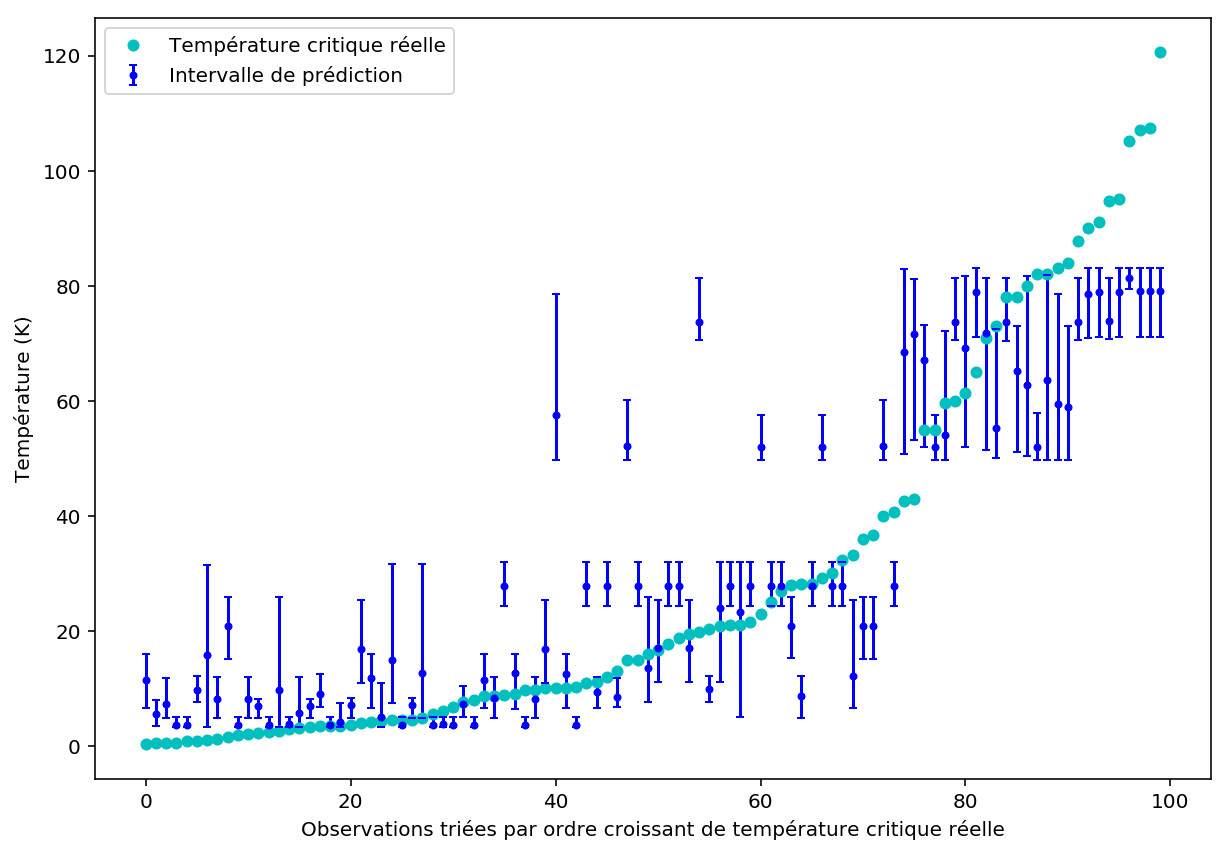

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, color='c', marker='o', markersize=5, label='Température critique réelle', linestyle='None')
plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', markersize=3, label='Intervalle de prédiction', capsize=2)
plt.ylabel('Température (K)')
plt.xlabel('Observations triées par ordre croissant de température critique réelle')
plt.legend(loc='upper left')
plt.show()

In [41]:
ground_truth_inside_interval = 0
for i, y_value in enumerate(y_test):
    if lower_bound_prediction_list[i] <= y_value <= upper_bound_prediction_list[i]:
        ground_truth_inside_interval += 1
ground_truth_inside_interval_percentage = ground_truth_inside_interval / float(len(y_test))
ground_truth_inside_interval_percentage

0.27

In [46]:
y_test.iloc[97]

82.0

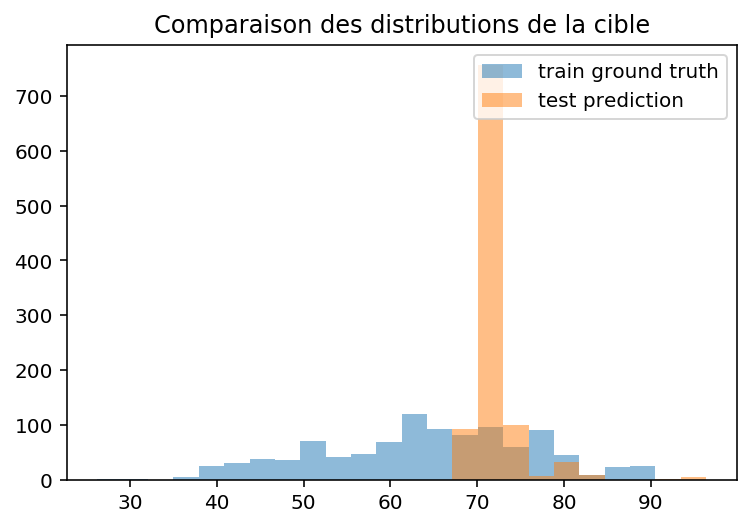

In [49]:
dt_pred_mat_1_obs_0 = [dt.predict(np.array([X_test.iloc[97]]))[0] for dt in rfqr.estimators_]
dt_pred_mat_100_obs_0 = [dt.predict(np.array([X_test.iloc[97]]))[0] + 20 for dt in rf.estimators_]


def plot_distribution_comparison(y_train, test_prediction, bins):
    bins = np.linspace(min(min(y_train), min(test_prediction)), max(max(y_train), max(test_prediction)), bins)
    plt.hist(y_train, bins, alpha=0.5, label='train ground truth')
    plt.hist(test_prediction, bins, alpha=0.5, label='test prediction', histtype='stepfilled')
    plt.title('Comparaison des distributions de la cible')
    plt.legend(loc='upper right')
    plt.show()

plot_distribution_comparison(dt_pred_mat_1_obs_0, dt_pred_mat_100_obs_0, 25)

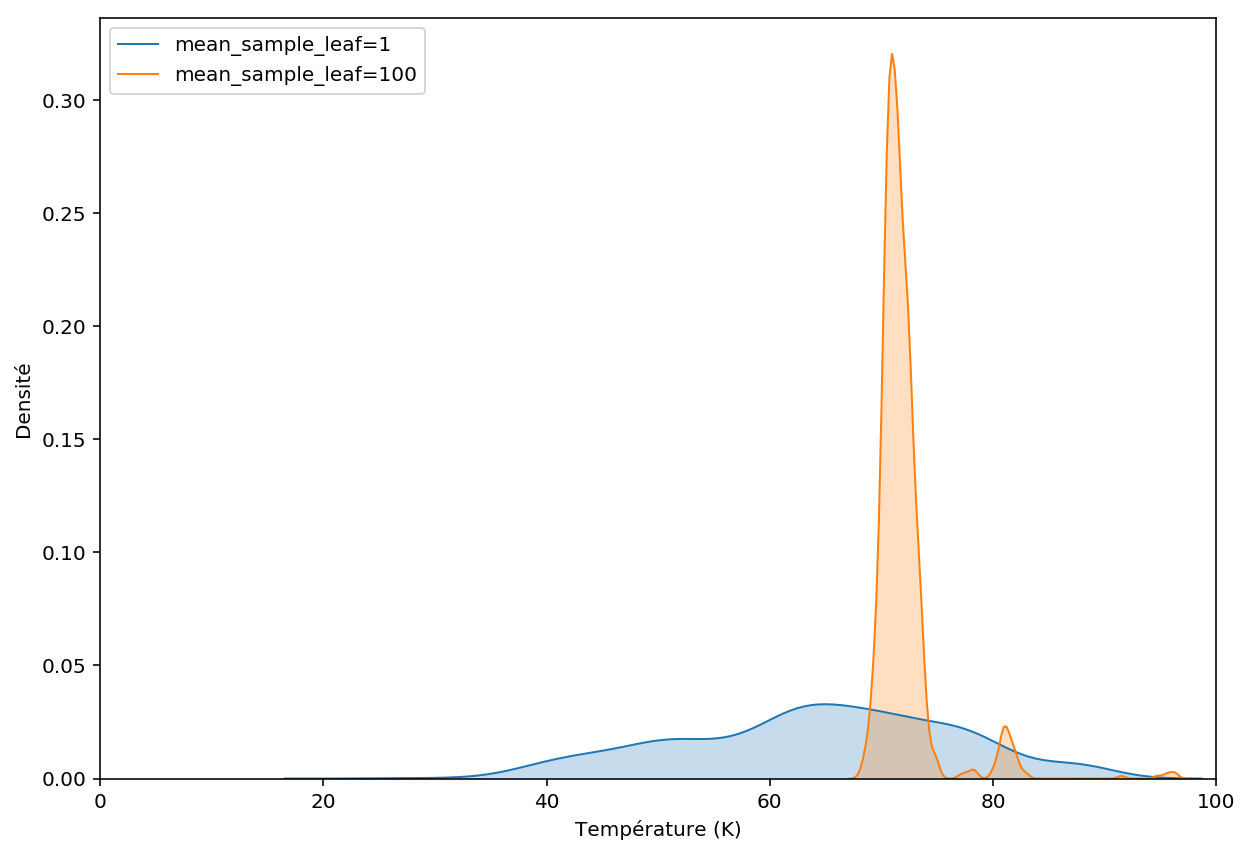

In [51]:
plt.figure(figsize=(10, 7))
sns.distplot(dt_pred_mat_1_obs_0,
             hist = False,
             kde = True,
             kde_kws = {'shade': True, 'linewidth': 1},
             label='mean_sample_leaf=1')
sns.distplot(dt_pred_mat_100_obs_0,
             hist = False,
             kde = True,
             kde_kws = {'shade': True, 'linewidth': 1},
             label='mean_sample_leaf=100')
plt.xlabel('Température (K)')
plt.ylabel('Densité')
plt.xlim(0,100)
plt.legend(loc='upper left')
plt.show()

In [20]:
# améliorer rf avec valeurs extrèmes ??
# NN reg + tester quantile reg

Ne pas confondre intervalle de confiance et de prediction :
- https://stats.stackexchange.com/questions/16493/difference-between-confidence-intervals-and-prediction-intervals